In [2]:
%tensorflow_version 2.x

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

TensorFlow 2.x selected.


In [0]:
import IPython
import signal

def interrupted(_interrupted=[False], _default=[None]):
    if _default[0] is None or signal.getsignal(signal.SIGINT) == _default[0]:
        _interrupted[0] = False
        def handle(signal, frame):
            if _interrupted[0] and _default[0] is not None:
                _default[0](signal, frame)
            print('Interrupt!')
            _interrupted[0] = True
        _default[0] = signal.signal(signal.SIGINT, handle)
    return _interrupted[0]

def enumerate_cycle(g):
    epoch = 0
    while True:
        for i,x in enumerate(g):
            yield (epoch,i), x
        epoch = epoch + 1

In [4]:
!rm -rf datasci-practical-b/
!git clone https://github.com/EmptyJackson/datasci-practical-b
%cd datasci-practical-b/

Cloning into 'datasci-practical-b'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 57 (delta 23), reused 41 (delta 13), pack-reused 0
Unpacking objects: 100% (57/57), done.
/content/datasci-practical-b


In [5]:
!git pull

Already up to date.


In [0]:
data = pd.read_csv("https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/Final_assignment/diabetes/diabetic_data_original.csv")
#data = pd.read_csv("https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/Final_assignment/diabetes/diabetic_data_balanced.csv")
ids = pd.read_csv("https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/Final_assignment/diabetes/IDs_mapping.csv")

In [0]:
from transformers import pipeline
df = pipeline.fit_transform(data)

In [0]:
"""BATCH_SIZE = 40
indexes = np.arange(len(x))
indexes = np.array_split(indexes, len(x) / BATCH_SIZE)
eb_indexes = enumerate_cycle(indexes)"""

## One shot model training

In [0]:
from datasets import get_sequence_dataset, get_oneshot_dataset
x, y = get_oneshot_dataset(df, multitask_attr="")#"num_medications")

In [0]:
from models import get_simple_regression
from metrics import tih_poisson

x_arr = np.array(x)
y_arr = np.array(y)
reg_model = get_simple_regression(x_arr.shape[1], multitask=False)

reg_model.compile(loss = keras.losses.poisson,
                  optimizer = keras.optimizers.Adam(1e-4),
                  metrics=[tih_poisson])

In [18]:
reg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                3296      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 8)                 0     

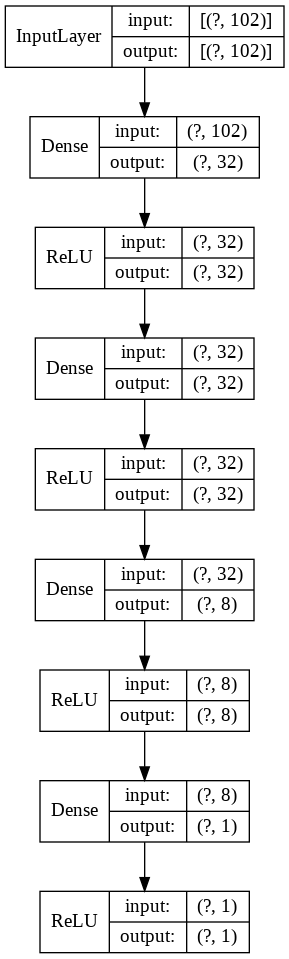

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(reg_model, show_shapes=True, show_layer_names=False, to_file='reg_model.png')

In [0]:
scaler = StandardScaler()
x_arr = scaler.fit_transform(x_arr)
assert not np.any(np.isnan(x_arr))

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

x_train, x_test, y_train, y_test = tsne_data_split(x_arr, y_arr)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in split.split(x_train, y_train):
    x_val, y_val = x_train[val_idx], y_train[val_idx]
    x_train, y_train = x_train[train_idx], y_train[train_idx]
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [0]:
y_val = y_val.astype('float32')
keras.losses.poisson(y_val, y_val)

In [0]:
y_train = y_train.astype('float32')
keras.losses.poisson(y_train, y_train)

In [0]:
base_history = reg_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=34, batch_size=32)

In [0]:
reg_model.evaluate(x_test, y_test)

In [0]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
train_plot, = plt.plot(base_history.history['loss'], label="Training")
val_plot, = plt.plot(base_history.history['val_loss'], label="Validation")
"""
plt.plot(multi_history.history['tih_poisson'])
plt.plot(multi_history.history['val_tih_poisson'])
"""
plt.legend(handles=[train_plot, val_plot])
ax.set_ylabel('Poisson loss')
ax.set_xlabel('Epoch')
ax.set_ylim([-3.0,-2.0])
#plt.savefig('base_train.png', dpi=200)
plt.show()

In [0]:
from metrics import convergence_point

convergence_point(base_history.history['val_loss'], conv_seq_len=50, ratio=0.5)

In [0]:
min(base_history.history['val_loss'])

## Multi-task model training

In [0]:
from datasets import get_sequence_dataset, get_oneshot_dataset
x, y = get_oneshot_dataset(df, multitask_attr="num_medications")

In [0]:
from models import get_simple_regression
from metrics import tih_poisson

x_arr = np.array(x)
y_arr = np.array(y)
multi_model = get_simple_regression(x_arr.shape[1], multitask=True)

multi_model.compile(loss = keras.losses.poisson,
                    optimizer = keras.optimizers.Adam(1e-4),
                    metrics=[tih_poisson])

In [21]:
multi_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                3296      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 8)                 0   

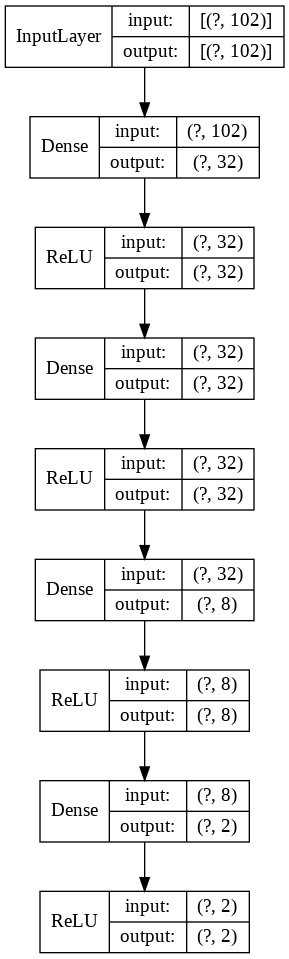

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(multi_model, show_shapes=True, show_layer_names=False)# to_file='reg_model.png')

In [0]:
scaler = StandardScaler()
x_arr = scaler.fit_transform(x_arr)
assert not np.any(np.isnan(x_arr))

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

x_train, x_test, y_train, y_test = tsne_data_split(x_arr, y_arr)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in split.split(x_train, y_train[:, 0]):
    x_val, y_val = x_train[val_idx], y_train[val_idx]
    x_train, y_train = x_train[train_idx], y_train[train_idx]
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [0]:
y_val = y_val.astype('float32')
tih_poisson(y_val, y_val)

In [0]:
y_train = y_train.astype('float32')
tih_poisson(y_train, y_train)

In [0]:
multi_history = multi_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=42, batch_size=32)

In [0]:
multi_model.evaluate(x_test, y_test)

In [0]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
train_plot, = plt.plot(multi_history.history['tih_poisson'], label="Training")
val_plot, = plt.plot(multi_history.history['val_tih_poisson'], label="Validation")
plt.legend(handles=[train_plot, val_plot])
ax.set_ylabel('Poisson loss')
ax.set_xlabel('Epoch')
ax.set_ylim([-2.6,-2.5])
#plt.savefig('multi_train.png', dpi=200)
plt.show()

In [0]:
from metrics import convergence_point

convergence_point(multi_history.history['val_tih_poisson'], conv_seq_len=25, ratio=0.5)

In [0]:
min(multi_history.history['val_tih_poisson'])

## Sequence model training

In [0]:
from datasets import get_sequence_dataset, get_oneshot_dataset
x, y = get_sequence_dataset(df)

In [0]:
"""def mask_poisson_loss(y_true, y_pred):
    i = 0
    while True:
        if y_true[i] == 0.:
            break
        i = i + 1
    return keras.losses.poisson(y_true[:i], y_pred[:i])
"""
"""
import keras.backend as K

def get_mask_loss(mask_value, loss_fn):
    def mask_loss(y_true, y_pred):
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        # find out which timesteps in `y_true` are not the padding value 0
        mask = K.equal(y_true, mask_value) #K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())

        # multiply poisson with the mask
        #tf.print(keras.losses.poisson(y_true, y_pred).shape)
        loss = loss_fn(y_true, y_pred) #* mask
        # take average w.r.t. the number of unmasked entries
        #return K.sum(loss) / K.sum(mask)
        return loss * tf.cast(tf.size(y_true), K.floatx()) / K.sum(mask)
    return mask_loss
"""

'\nimport keras.backend as K\n\ndef get_mask_loss(mask_value, loss_fn):\n    def mask_loss(y_true, y_pred):\n        y_true = K.flatten(y_true)\n        y_pred = K.flatten(y_pred)\n        # find out which timesteps in `y_true` are not the padding value 0\n        mask = K.equal(y_true, mask_value) #K.all(K.equal(y_true, mask_value), axis=-1)\n        mask = 1 - K.cast(mask, K.floatx())\n\n        # multiply poisson with the mask\n        #tf.print(keras.losses.poisson(y_true, y_pred).shape)\n        loss = loss_fn(y_true, y_pred) #* mask\n        # take average w.r.t. the number of unmasked entries\n        #return K.sum(loss) / K.sum(mask)\n        return loss * tf.cast(tf.size(y_true), K.floatx()) / K.sum(mask)\n    return mask_loss\n'

In [0]:
def get_seq_model(num_features=102, seq_len=5, dropout=False):
    inputs = keras.layers.Input(shape=(seq_len,num_features))
    x = keras.layers.Masking(mask_value=0, input_shape=(seq_len, num_features))(inputs)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.ReLU()(x)
    #x = keras.layers.Dense(32)(x)
    #x = keras.layers.ReLU()(x)
    if dropout:
        x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.GRU(units=32, return_sequences=True)(x)
    if dropout:
        x = keras.layers.Dropout(0.5)(x)
    #x = keras.layers.GRU(units=32, return_sequences=True)(x)
    #x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dense(8)(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.ReLU()(x)
    return keras.models.Model(inputs=inputs, outputs=outputs)

In [0]:
# from models import get_seq_model
from metrics import get_mask_loss
seq_len = 39
x_arr = np.array([np.array(i) for i in x])
x_arr = keras.preprocessing.sequence.pad_sequences(x_arr, maxlen=seq_len, padding="post", truncating="post")
y_arr = np.array([np.array(i) for i in y])
y_arr = keras.preprocessing.sequence.pad_sequences(y_arr, maxlen=seq_len, padding="post", truncating="post")

seq_model = get_seq_model(x_arr[0][0].shape[0], seq_len=seq_len, dropout=True)

seq_model.compile(loss = get_mask_loss(0, keras.losses.poisson),
                  optimizer = keras.optimizers.Adam(5e-4),
                  metrics=[get_mask_loss(0, keras.losses.mean_absolute_error)])

In [43]:
max([len(l) for l in x])

39

In [47]:
seq_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 39, 102)]         0         
_________________________________________________________________
masking_6 (Masking)          (None, 39, 102)           0         
_________________________________________________________________
dense_26 (Dense)             (None, 39, 32)            3296      
_________________________________________________________________
re_lu_32 (ReLU)              (None, 39, 32)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 39, 32)            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 39, 32)            6336      
_________________________________________________________________
dropout_11 (Dropout)         (None, 39, 32)            0   

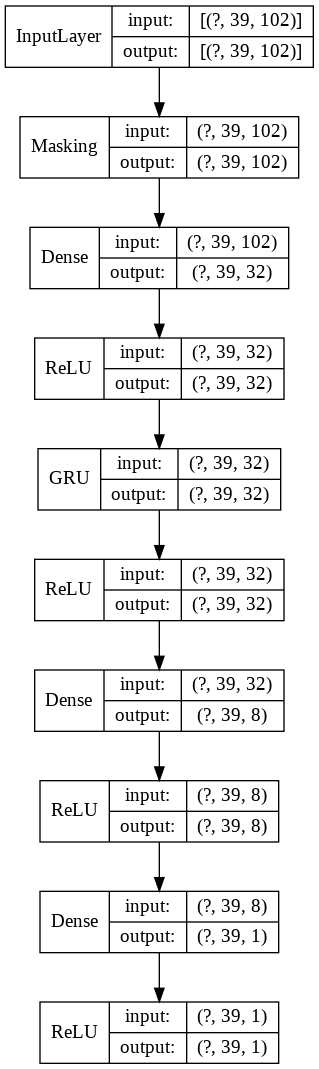

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(seq_model, show_shapes=True, show_layer_names=False, to_file='no_drop_seq_model.png')

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = tsne_data_split(x_arr, y_arr)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=45)

In [53]:
y_test = y_test.astype('float32')
get_mask_loss(0, keras.losses.poisson)(y_test, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.4893003>

In [51]:
y_val = y_val.astype('float32')
get_mask_loss(0, keras.losses.poisson)(y_val, y_val)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.4029133>

In [52]:
y_train = y_train.astype('float32')
get_mask_loss(0, keras.losses.poisson)(y_train, y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.4302983>

In [0]:
seq_40_history = seq_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=105, batch_size=32)

In [0]:
seq_model.evaluate(x_test, y_test)

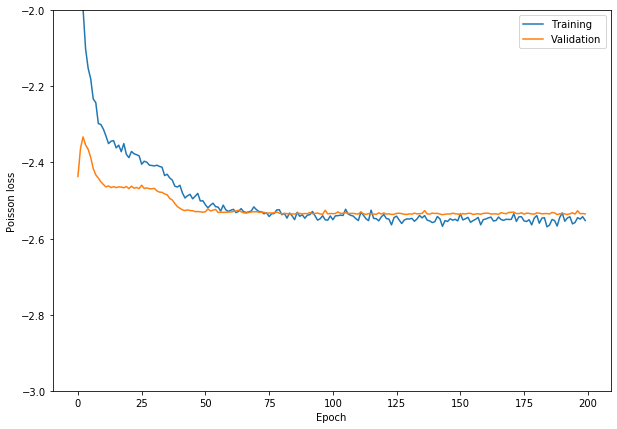

In [170]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
train_plot, = plt.plot(seq_40_history.history['loss'], label="Training")
val_plot, = plt.plot(seq_40_history.history['val_loss'], label="Validation")
plt.legend(handles=[train_plot, val_plot])
ax.set_ylabel('Poisson loss')
ax.set_xlabel('Epoch')
ax.set_ylim([-3.0,-2.0])
plt.savefig('rec_train.png', dpi=200)
#plt.show()

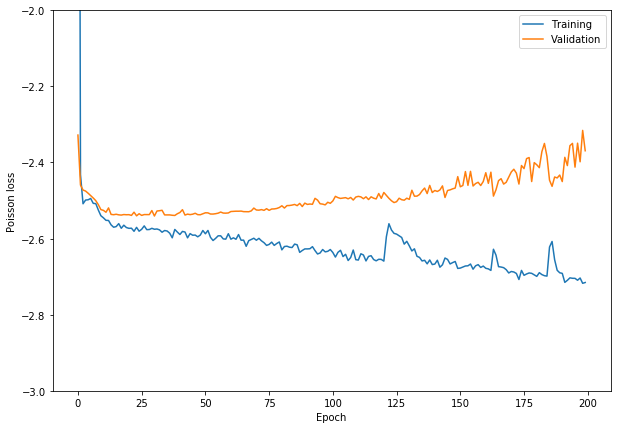

In [169]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
train_plot, = plt.plot(no_drop_seq_history.history['loss'], label="Training")
val_plot, = plt.plot(no_drop_seq_history.history['val_loss'], label="Validation")
plt.legend(handles=[train_plot, val_plot])
ax.set_ylabel('Poisson loss')
ax.set_xlabel('Epoch')
ax.set_ylim([-3.0,-2.0])
plt.savefig('no_drop_rec_train.png', dpi=200)
#plt.show()

In [0]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
train_plot, = plt.plot(seq_history.history['loss'], label="Training")
val_plot, = plt.plot(seq_history.history['val_loss'], label="Validation")
plt.legend(handles=[train_plot, val_plot])
ax.set_ylabel('Poisson loss')
ax.set_xlabel('Epoch')
ax.set_ylim([-3.0,-2.0])
plt.savefig('rec_train.png', dpi=200)
#plt.show()

In [0]:
drop_25_seq_history = seq_history

In [0]:
drop_50_seq_history = seq_history

In [0]:
from metrics import convergence_point

convergence_point(no_drop_seq_history.history['val_loss'], conv_seq_len=60, ratio=0.5)

In [0]:
min(seq_history.history['val_loss'])

## Model comparison

In [0]:
print(base_history.history['val_loss'])

In [0]:
print(multi_history.history['val_tih_poisson'])

In [0]:
print(seq_history.history['val_loss'])

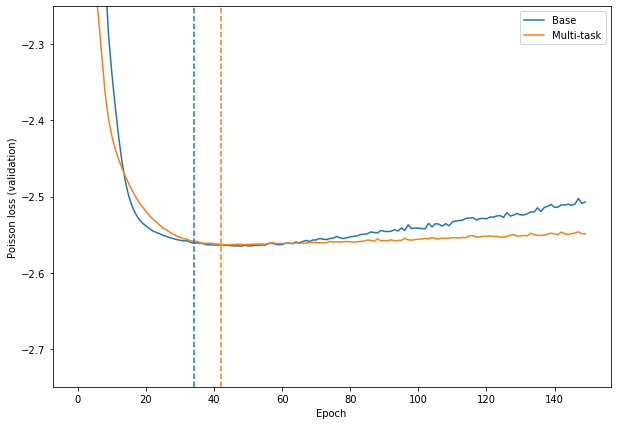

In [206]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
base_plot, = plt.plot(base_history.history['val_loss'], label="Base", c='C0')
multi_plot, = plt.plot(multi_history.history['val_tih_poisson'], label="Multi-task", c='C1')

plt.legend(handles=[base_plot, multi_plot])
ax.set_ylabel('Poisson loss (validation)')
ax.set_xlabel('Epoch')
ax.set_ylim([-2.75,-2.25])
plt.axvline(x=34, c='C0', linestyle='dashed')
plt.axvline(x=42, c='C1', linestyle='dashed')
plt.savefig('base_multi_conv.png', dpi=200)
#plt.show()

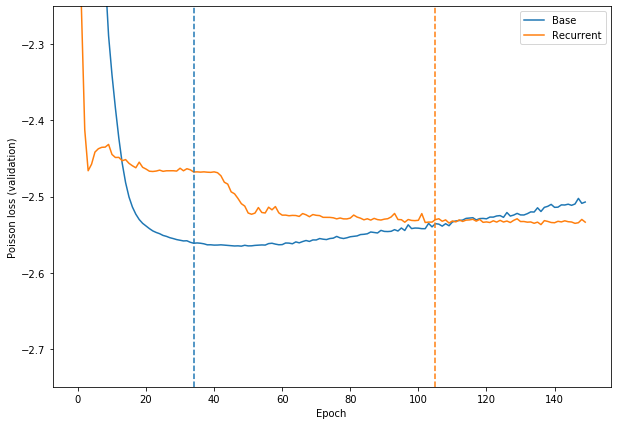

In [205]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
base_plot, = plt.plot(base_history.history['val_loss'], label="Base", c='C0')
seq_plot, = plt.plot(seq_history.history['val_loss'][:150], label="Recurrent", c='C1')

plt.legend(handles=[base_plot, seq_plot])
ax.set_ylabel('Poisson loss (validation)')
ax.set_xlabel('Epoch')
ax.set_ylim([-2.75,-2.25])
plt.axvline(x=34, c='C0', linestyle='dashed')
plt.axvline(x=105, c='C1', linestyle='dashed')
#plt.savefig('base_rec_conv.png', dpi=200)
plt.show()

In [0]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
base_plot, = plt.plot(base_history.history['val_loss'], label="Base", c='C0')
seq_plot, = plt.plot(seq_history.history['val_loss'][:150], label="Recurrent", c='C1')

plt.legend(handles=[base_plot, seq_plot])
ax.set_ylabel('Poisson loss (validation)')
ax.set_xlabel('Epoch')
ax.set_ylim([-2.75,-2.25])
plt.axvline(x=34, c='C0', linestyle='dashed')
plt.axvline(x=105, c='C1', linestyle='dashed')
#plt.savefig('base_rec_conv.png', dpi=200)
plt.show()

## Old training code

In [0]:
"""loss_history = []"""

'loss_history = []'

In [0]:
"""last_epoch = -1
epoch_loss = []
val_loss = []
while not interrupted():
    (epoch,batch),i = next(eb_indexes)
    loss = reg_model.train_on_batch(x_arr[i], y_arr[i])
    if batch == 0 and epoch != 0:
        val_loss.append(reg_model.evaluate(x_arr, y_arr, verbose=0))
        loss_history.append((epoch+batch/len(indexes), sum(epoch_loss)/len(epoch_loss)))
        if epoch >= last_epoch + 1:
            last_epoch = epoch
            if epoch % 20 == 0:
                IPython.display.clear_output(wait=True)
            print(f'train loss={sum(epoch_loss)/len(epoch_loss)} val loss={val_loss[-1]} epoch={epoch}') #batchnum={batch}/{len(indexes)}')
        epoch_loss = []
    epoch_loss.append(loss)"""

"last_epoch = -1\nepoch_loss = []\nval_loss = []\nwhile not interrupted():\n    (epoch,batch),i = next(eb_indexes)\n    loss = reg_model.train_on_batch(x_arr[i], y_arr[i])\n    if batch == 0 and epoch != 0:\n        val_loss.append(reg_model.evaluate(x_arr, y_arr, verbose=0))\n        loss_history.append((epoch+batch/len(indexes), sum(epoch_loss)/len(epoch_loss)))\n        if epoch >= last_epoch + 1:\n            last_epoch = epoch\n            if epoch % 20 == 0:\n                IPython.display.clear_output(wait=True)\n            print(f'train loss={sum(epoch_loss)/len(epoch_loss)} val loss={val_loss[-1]} epoch={epoch}') #batchnum={batch}/{len(indexes)}')\n        epoch_loss = []\n    epoch_loss.append(loss)"

In [0]:
"""# Simple plot of the training loss
df = pd.DataFrame.from_records(loss_history, columns=['epoch','loss'])
print("Final training loss:", df.loss.ewm(com=10).mean().iloc[-1])
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(df.epoch, df.loss)
ax.plot(df.epoch, df.loss.ewm(com=10).mean(), linewidth=3)
#ax.set_ylim([-5,0])
plt.show()"""

'# Simple plot of the training loss\ndf = pd.DataFrame.from_records(loss_history, columns=[\'epoch\',\'loss\'])\nprint("Final training loss:", df.loss.ewm(com=10).mean().iloc[-1])\nfig,ax = plt.subplots(figsize=(12,4))\nax.plot(df.epoch, df.loss)\nax.plot(df.epoch, df.loss.ewm(com=10).mean(), linewidth=3)\n#ax.set_ylim([-5,0])\nplt.show()'